# Deep Learning for Recommender Systems (Part 2)

In the previous notebook, we managed to build a simple `NN` with a `Retrieval` and `Ranking` model. In this notebook, we will expand on that and aim to build a more complicated model with all the features we have available in our dataset.

Let's jump right in!

This is the **FIFTH** of five notebooks:<br>
[1. Data Exploration and EDA](1_Data_Exploration_and_EDA.ipynb)</br>
[2. Simple Content and Collaborative Filtering Methods](2_Simple_Content_and_Collaborative_Filtering_Models.ipynb)</br>
[3. Surprise Library Models](3_Surprise_Library_Models.ipynb)</br>
[4. Deep Learning Part 1](4_Deep_Learning_Part_1_(Basic).ipynb)</br>
**5. Deep Learning Part 2 (Current Notebook)**</br>

# Contents of this notebook:
[1. Imports](#Imports)<br>
[2. Reading in the data](#Reading-in-the-data)<br>
[3. Model Architecture](#Model-Architecture)<br>
[4. Retrieval Model](#Retrieval-Model)<br>
* [MovieIds and UserIds](#MovieIds-and-UserIds)<br>
* [Genres](#Genres)<br>
* [Movie Titles](#Movie-Titles)<br>
* [Query Tower](#Query-Tower)<br>
* [Candidate Tower](#Candidate-Tower)<br>
* [Combined Retrieval Model](#Combined-Retrieval-Model)<br>

[5. Running the Retrieval model](#Running-the-Retrieval-model)<br>
* [Evaluating the different depths](#Evaluating-the-different-depths)<br>
* [Querying the Retrieval Model](#Querying-the-Retrieval-Model)<br>

[6. Ranking Model](#Ranking-Model)<br>
* [Creating the RankingModel classes](#Creating-the-RankingModel-classes)<br>

[7. Running the Ranking model](#Running-the-Ranking-model)<br>
[8. Getting Predictions](#Getting-Predictions)<br>
[9. Custom Prediction Function](#Custom-Prediction-Function)<br>
[10. Overall Model Evaluation](#Overall-Model-Evaluation)<br>
* [Pros of the Neural Network Model](#Pros-of-the-Neural-Network-Model)<br>
* [Cons of the Neural Network Model](#Cons-of-the-Neural-Network-Model)<br>

[11. Next Steps](#Next-Steps)<br>
[12. Learnings from this challenge](#Learnings-from-this-challenge)<br>

---

# Imports

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import tensorflow_recommenders as tfrs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

---

# Reading in the data

In [4]:
df = pd.read_csv('./datasets/merged_users+movies.csv')
movie_df = pd.read_csv('./datasets/movies.csv')

In [5]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy


In a deep learning model, we can make use of features that we were not able to do so with our `SVD` model previously.<br>

We will attempt to create a deep learning model using all 6 features of our dataset. Namely these are: `userId`, `movieId`, `rating`, `timestamp`, `title`, `genres`.

We will keep the overall structure of our model the same as before. To make things clear, I have drawn out the architecture of the model below

---

# Model Architecture

For more details about how the model works, please check out the `TensorFlow-Recommenders` documentation and guide [here](https://www.tensorflow.org/recommenders).

## Overall Model Architecture

![overall](images/model_structure_1.png)

## Retrieval Model Architecture

We will keep the embedding dimensions the same, the final model we ended up with was the 3 layer model with the number of neurons per layer as shown below.

![retrieval](images/retrieval_structure.png)

## Ranking Model Architecture

For the ranking model, we've kept it largely the same, we just added one more deep layer, and ran through more epochs. We also tried changing the learning rate to `0.01` and that seemed to have had a positive effect.

![ranking](images/ranking_structure.png)

---

# Retrieval Model

In order to add all the features to our model, we will need to create `embeddings` for each of them. We can use the `Embedding` method in `Keras` to help with this. Let's start by first creating a tensorflow compatible dataset that we will then use for creation of any `embeddings` we need.

We will start off by converting our all our required data to a tensorflow dataset that will work with methods like `batch` and `map`.

In [8]:
retrieval_dataset = {
    'movieId': df['movieId'].tolist(),
    'genres': df['genres'].tolist(),
    'title': df['title'].tolist(),
    'userId': df['userId'].tolist(),
    'timestamp': df['timestamp'].tolist(),
}

In [9]:
retrieval_dataset = tf.data.Dataset.from_tensor_slices(retrieval_dataset)

In [10]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [78]:
retrieval_dataset = retrieval_dataset.map(lambda x: {
    'movieId': x['movieId'],
    'genres': x['genres'],
    'title': x['title'],
    'userId': x['userId'],
    'timestamp': x['timestamp'],
})

# creating separate datasets in case we need to use them to be 
# added to the model.
movies = retrieval_dataset.map(lambda x: x['movieId'])
genres = retrieval_dataset.map(lambda x: x['genres'])
movie_titles = retrieval_dataset.map(lambda x: x['title'])
users = retrieval_dataset.map(lambda x: x['userId'])
timestamps = retrieval_dataset.map(lambda x: x['timestamp'])
movie_related = retrieval_dataset.map(lambda x: {
    'movieId': x['movieId'],
    'genres': x['genres'],
    'title': x['title']
})

In [12]:
# sanity check once again to ensure that we have 
# a 'MapDataset' object
retrieval_dataset

<MapDataset element_spec={'movieId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'genres': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None), 'userId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

Now let's create the vocabularies for our `categorical` embeddings.

---

## MovieIds and UserIds

In [13]:
# creating a list of unique userIds
unique_user_ids = np.unique(df['userId'].tolist())

# creating a list of unique movieIds
unique_movie_ids = np.unique(df['movieId'].tolist())

In [14]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [15]:
# defining the embedding dimension that we will use across all embedding 
# layers. We have kept this number relatively small so that the model will 
# work a little faster.
embedding_dimension = 32

In [16]:
# embedding unique userIds
user_id_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(
        vocabulary=unique_user_ids, mask_token=None),
    # We add some additional embeddings to account for unknown tokens.
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [17]:
# check to see the vector embedding of 'userIds'
user_id_model([512])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.00081122, -0.02875767, -0.04360918, -0.01942483, -0.04483289,
        -0.04232473, -0.00328261,  0.03390611, -0.01417794,  0.03610729,
         0.02313039, -0.04455442,  0.03058723, -0.023033  , -0.03950164,
        -0.04518759,  0.00608736,  0.00129064,  0.00457434, -0.01988406,
        -0.02892946, -0.0474653 , -0.00715746,  0.04118115,  0.00501484,
        -0.00406092, -0.04110572,  0.03379187,  0.02222545,  0.02411193,
        -0.0143726 ,  0.01857961]], dtype=float32)>

In [18]:
# defining an empty dictionary to store the predicted ratingsaaaaaaaaaaaaaaaaaa

In [19]:
# embedding unique movie titles
movie_id_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(
        vocabulary=unique_movie_ids, mask_token=None), 
    # We add some additional embeddings to account for unknown tokens.    
    tf.keras.layers.Embedding(len(unique_movie_ids) + 1, 
                              embedding_dimension)
])


In [20]:
movie_id_model([9772])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.01577159, -0.03597652, -0.04406003, -0.00708966,  0.04410957,
        -0.00859253,  0.03370399, -0.04356829, -0.02139441, -0.04574819,
         0.01672593,  0.04311106, -0.00391455,  0.04563994,  0.0453303 ,
         0.01165255, -0.02140977,  0.01890771, -0.01297603, -0.026446  ,
         0.04934862,  0.012067  , -0.01430515,  0.01237873, -0.04249377,
         0.00539269,  0.00693144, -0.04606635,  0.00485566,  0.00824876,
        -0.01065079,  0.01006881]], dtype=float32)>

---

### Genres

Next we will create a `word embedding` for the genres feature.
There are 34 movies in the `movies_df` that have 'no genres listed'. This may cause our model with the genres feature added into it to recommend movies with genres list, and not those without any genres. However we will still add genres into our model and for those with 'no genres listed', ....

We will use the inbuilt text vectorizer in keras to vectorize our genres for us.

In [23]:
# defining max_tokens for use in vectorizers
max_tokens = 10_000

In [24]:
# initializing the vectorizer
genre_text = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=1,
    output_mode='int',
)

In [25]:
# using adapt method to get vocab
genre_text.adapt(genres)

In [26]:
# creating the embedding layer
genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=max_tokens,
    output_dim=embedding_dimension,
    mask_zero=True,
)

In [28]:
# embedding genres
genres_model = tf.keras.Sequential([genre_text, 
                                    genre_embedding,
                                    tf.keras.layers.GlobalAveragePooling1D()
                                   ])

In [29]:
# sanity to check to ensure it has been done properly
genres_model(['Adventure Animation Children Comedy Fantasy'])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.00583466,  0.01426386,  0.01211957,  0.00869819,  0.03331385,
        -0.01178429,  0.01008566,  0.03154489, -0.00229541,  0.01152138,
         0.03370294,  0.00079418,  0.01142957, -0.00050997, -0.01653682,
        -0.02293302,  0.00657728,  0.01717502, -0.0086735 ,  0.02924502,
         0.00860718,  0.00576533,  0.01102587, -0.00850808,  0.00587832,
        -0.01510449,  0.00360906,  0.0103816 , -0.01017557, -0.00611506,
         0.00241281,  0.009604  ]], dtype=float32)>

---

### Movie Titles

Next we will create a `word embedding` for the `title` feature.
Since there are some movies with missing genres, and since we have the `title` feature available to use, we will add this in to our deep learning model. 

We will use the inbuilt text vectorizer in keras to vectorize our movie titles for us.

In [30]:
# initializing the vectorizer
title_text = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens
)

In [31]:
# using adapt method to get vocabulary
title_text.adapt(movie_titles)

In [32]:
# creating the embedding layer
title_embedding = tf.keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dimension,
    mask_zero=True,   
)

In [34]:
# embedding titles
titles_model = tf.keras.Sequential([title_text, 
                                    title_embedding, 
                                    tf.keras.layers.GlobalAveragePooling1D()
                                   ])

---

### Timestamp

Now let's handle the `timestamp` feature. Let's first take a look at what we are working with.

In [35]:
df['timestamp'].head()

0     964982703
1     847434962
2    1106635946
3    1510577970
4    1305696483
Name: timestamp, dtype: int64

These numbers are too large for us to directly use in a deep model. So we will first preprocess it.<br>

There are a few methods to do this. However to keep things simple, we will do this as per the [tensorflow-recommenders guide](https://www.tensorflow.org/recommenders/examples/featurization), with discretion.

In [36]:
# getting the max and min values
max_timestamp = retrieval_dataset.map(lambda x: x["timestamp"]).reduce(
    tf.cast(0, tf.int32), tf.maximum).numpy().max()
min_timestamp = retrieval_dataset.map(lambda x: x["timestamp"]).reduce(
    np.int32(1e9), tf.minimum).numpy().min()

# creating buckets
timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

print(f"Buckets: {timestamp_buckets[:3]}")

Buckets: [8.28124615e+08 8.28835000e+08 8.29545385e+08]


In [37]:
# embedding timestamp
timestamp_embedding_model = tf.keras.Sequential([
  tf.keras.layers.Discretization(timestamp_buckets.tolist()),
  tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
])

# check to see how timestamp has been vectorized
for timestamp in retrieval_dataset.take(1).map(lambda x: x["timestamp"]).\
batch(1).as_numpy_iterator():
  print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}.")

Timestamp embedding: [[ 0.02029595 -0.04984224  0.026773    0.0451501  -0.02596587  0.04548092
   0.00908453  0.02414939  0.03531845 -0.00969007 -0.02192471 -0.03559488
   0.00668986  0.02945537  0.01807607 -0.03582012 -0.04681113 -0.02754462
  -0.00475822  0.00580887  0.03047646  0.03907968  0.04415162  0.02680471
   0.02846401  0.00576955 -0.015428    0.02374153  0.02423288 -0.03800857
   0.0380904  -0.00707637]].


With this done, we can move on to building the candidate and query towers.

---

## Query Tower

While building the `Query` and `Candidate` towers, we will not be able to reuse the previously instantiate models (e.g. `user_id_model`, as we will run into errors while saving them. We will have to reinstantiate all of them.

In [81]:
class UserModel(tf.keras.Model):
    """Model to accept features and pass back embeddings."""

    def __init__(self):
        super().__init__()

        # using previously defined and created user_id_model
        self.user_embedding = user_id_model

        # using previously defined and created timestamp_embedding_model
        self.timestamp_embedding = timestamp_embedding_model
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )
        
        # normalizing the timestamp
        self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs['userId']),
            self.timestamp_embedding(inputs['timestamp']),
            tf.reshape(self.normalized_timestamp(inputs['timestamp']), (-1, 1))
        ], axis=1)

In [82]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()    

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, 
                                                      activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

---

## Candidate Tower

In [110]:
class MovieModel(tf.keras.Model):
    """Model to accept features and pass back embeddings."""

    def __init__(self):
        super().__init__()

        # using previously defined and created movie_id_model
        self.movie_id_embedding = movie_id_model
        
        # using previously defined and created genres_model
        self.genre_text_embedding = genres_model

        # using previously defined and created titles_model
        self.title_text_embedding = titles_model

    def call(self, inputs):    
        return tf.concat([
                self.genre_text_embedding(inputs['genres']),
                self.movie_id_embedding(inputs['movieId']),
                self.title_text_embedding(inputs['title'])
            ], axis=1)

In [111]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = MovieModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, 
                                                      activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

Now all that is left to do is to combine these two towers into one retrieval model.

---

## Combined Retrieval Model

In [112]:
class MovielensModel_retrieval(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movie_related.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        
        query_embeddings = self.query_model({
            'userId': features['userId'],
            'timestamp': features['timestamp'],
            'genres': features['genres'],
            'title': features['title']
        })

        movie_embeddings = self.candidate_model({
            'movieId': features['movieId'],
            'genres': features['genres'],
            'title': features['title']
        })

        return self.task(
            query_embeddings, movie_embeddings, compute_metrics=not training)

Now with the model built, we are ready to train our model.

---

## Train, Test split

Now we are ready to train our model, let's do a train_test_split on our data.

In [43]:
# setting random seed
tf.random.set_seed(42)

# shuffling the dataset to create a "training" dataset
retrieval_shuffled = retrieval_dataset.shuffle(100_000, 
                           seed=42,
                           reshuffle_each_iteration=False)


# taking the first 80_836 ratings
retrieval_train = retrieval_shuffled.take(80_836)

# taking the next 20_000 ratings
retrieval_test = retrieval_shuffled.skip(80_836).take(20_000)



# caching the train and test dataset to speed up model fitting
retrieval_cached_train = retrieval_train.shuffle(100_000)\
                            .batch(8192).cache()
retrieval_cached_test = retrieval_test.batch(4096).cache()

Trial for model with seperated user and movie features

---

# Running the Retrieval model

In [175]:
# defining the number of epochs we will run
num_epochs = 30

# instantiate a 1 layer retrieval model with 32 neurons
retrieval_1_layer = MovielensModel_retrieval([32])

# compiling model with Adagrad optimzier, and a learning rate of 0.05
retrieval_1_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))

In [176]:
# fitting our model
retrieval_1_layer_history = retrieval_1_layer.fit(
    retrieval_cached_train,
    validation_data=retrieval_cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

In [177]:
# instantiating a 2 layer retrieval model with 64, and 32 neurons
retrieval_2_layer = MovielensModel_retrieval([64, 32])

# compiling model with Adagrad optimzier, and a learning rate of 0.05
retrieval_2_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))

In [178]:
# fitting a 2 layer model neural network
retrieval_2_layer_history= retrieval_2_layer.fit(
    retrieval_cached_train,
    validation_data=retrieval_cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

In [179]:
# instantiating a 3 layer retrieval model with 128, 64, and 32 neurons
retrieval_3_layer = MovielensModel_retrieval([128, 64, 32])

# compiling model with Adagrad optimzier, and a learning rate of 0.05
retrieval_3_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))

In [180]:
# fitting a 3 layer model neural network
retrieval_3_layer_history= retrieval_3_layer.fit(
    retrieval_cached_train,
    validation_data=retrieval_cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

Now that we have tried out a model with 1 layer, and a model with 2 layers, let's take a look at each of their performances to see which one has performed better.

First let's evaluate each model individually by plotting the `train_loss` against the `test_loss`.

Now let's take a look at which `RetrievalModel` gave us a better performance in terms of accuracy.

---

## Evaluating the different depths

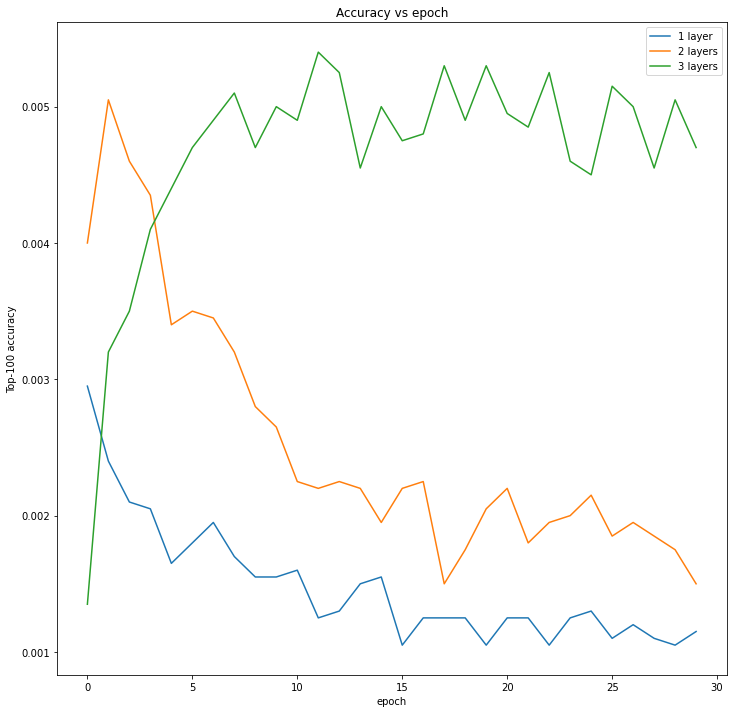

In [182]:
epochs = [_ for _ in range(num_epochs)]

plt.figure(figsize=(12,12))
plt.plot(epochs, retrieval_1_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, retrieval_2_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, retrieval_3_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend();

In [183]:
accuracy_1_layer = retrieval_1_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
accuracy_2_layer = retrieval_2_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
accuracy_3_layer = retrieval_3_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy for 1 layer model: {accuracy_1_layer:.4f}.")
print(f"Top-100 accuracy for 2 layer model: {accuracy_2_layer:.4f}.")
print(f"Top-100 accuracy for 3 layer model: {accuracy_3_layer:.4f}.")

Top-100 accuracy for 1 layer model: 0.0012.
Top-100 accuracy for 2 layer model: 0.0015.
Top-100 accuracy for 3 layer model: 0.0047.


First of all, let's recall that the accuracy score for our first basic neural network model was **0.019%**. We have improved this score by 23 times to **0.47%**, just from adding more layers and adding in the additional context features to our model.

As we can see above, the `3 layer` model performs  better than both the `1 layer` and the `2 layer` model. We would intuitively think that a deeper model will perform better, however, careful tuning is required for a deeper model to perform well.

An example of a hyperparameter that could be tuned is different optimizers, and different learning rates. There are a whole host of other hyper parameters that could be tuned as well.

For now, since the `3 layer` model has performed best, we will use that model going forward in this notebook. 

---

## Querying the Retrieval Model

Let's test querying the model for retrieving potential recommendations for a `userId`. For this we will make use of `BruteForce` as outlined in the tensorflow-recommender system guide.

In [189]:
%%time
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_3_layer.query_model,
                                                k=100)

# recommends movieIds out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), 
                       movies.batch(100)\
                       .map(retrieval_3_layer\
                            .candidate_model\
                            .embedding_model\
                            .movie_id_embedding)
                      )
                     )
)


# Get recommendations for a random 'userId', 512
_, m_ids = index({'userId': tf.constant([512]), 'timestamp': tf.constant([round(time.time())])})
print(f"Recommendations for user 512: {np.unique(m_ids)}")

Recommendations for user 512: [  2457   6104   7843   8383  32460  66198  69278  71252  72167  78116
  79073  82053  86504  86835  90430  90890  92439  95307  96520  96728
 102123 113573 125221 127323 137517 152711 160271 165075]
CPU times: total: 3.48 s
Wall time: 933 ms


Now we have recommendations for `userId` **512**. However, just for sanity's sake, lets check once to see if these are new titles that are being recommended, or if some of these titles have already been seen by this user.

*Note: The above can be modified to give us recommended genres, or recommended movie_text_titles as well!*

In [190]:
# get a list of movieIds already watched by userId 512
seen_mids_512 = df.loc[df['userId'] == 512, 'movieId'].unique().tolist()

# defining a list of unique recommended titles for userId 512
unique_reco_mids = np.unique([mid for mid in m_ids.numpy()[0]])

# getting a list of repeated titles
repeated_mids_reco = [mid for mid in unique_reco_mids if mid in seen_mids_512]

if repeated_mids_reco:
    for mid in repeated_mids_reco:
        print(f'{mid} is a repeated title')
else:
    print(f'{len(repeated_mids_reco)} recommendations are repeated.')

0 recommendations are repeated.


As we can see from the above output, it seems that the model has learnt to give unique recommendations on it's own. 
This could be (how many times on average does a user watch a movie?)

For further exploration, I found out that there is a method called [query_with_exclusions](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/layers/factorized_top_k/TopK#query_with_exclusions), that works if we want only want to get recommendations that have not been seen before.

---

# Ranking Model

Previously, we created a basic `ranking_model` where we only used 2 features of the dataset:
1. `userId`
2. `movieId`

and the target: `rating`. In the following model, we are going to add all the features in our dataset, similar to what we did for the `retrieval` model in the hopes of improved performance.

Let's start out by first creating the dataset that we will need. This time we will need to use the `rating` feature, so we will create a new dataset to keep things neat.<br> 

*There may be other more efficient ways to convert a dataset to a tensor dataset, however, for use in a recommender system, I found that the guide used a `mapdataset` object. As such I have used the following technique to achieve the same.*

In [191]:
# creating a dictionary of all the features we need
ranking_dataset = {
    'movieId': df['movieId'].tolist(),
    'genres': df['genres'].tolist(),
    'title': df['title'].tolist(),
    'userId': df['userId'].tolist(),
    'timestamp': df['timestamp'].tolist(), 
    'rating': df['rating'].tolist()
}

# converting dictionary to tensor
ranking_dataset = tf.data.Dataset.from_tensor_slices(ranking_dataset)

# creating a mapdataset object
ranking_dataset = ranking_dataset.map(lambda x: {
    'movieId': x['movieId'],
    'genres': x['genres'],
    'title': x['title'],
    'userId': x['userId'],
    'timestamp': x['timestamp'],
    'rating': x['rating']
})

In [192]:
# sanity check to ensure we have a mapdataset object
ranking_dataset

<MapDataset element_spec={'movieId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'genres': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None), 'userId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int32, name=None), 'rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

---

## Creating the RankingModel classes

In [193]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        # using previously defined and created user_id_model
        self.user_embedding = user_id_model

        # Compute embeddings for movies.
        # using previously defined and created movie_id_model
        self.movie_id_embedding = movie_id_model

        # using previously defined and created timestamp_embedding_model
        self.timestamp_embedding = timestamp_embedding_model
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )

        self.normalized_timestamp.adapt(timestamps)

        # using previously defined and created genres_model
        self.genre_text_embedding = genres_model

        # using previously defined and created titles_model
        self.title_text_embedding = titles_model

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):

        return self.ratings(tf.concat([
            self.user_embedding(inputs['userId']),
            self.movie_id_embedding(inputs['movieId']),
            self.timestamp_embedding(inputs['timestamp']),
            tf.reshape(self.normalized_timestamp(inputs['timestamp']), (-1, 1)),
            self.genre_text_embedding(inputs['genres']),
            self.title_text_embedding(inputs['title'])
        ], axis=1))

In [194]:
class MovielensModel_ranking(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features)-> tf.Tensor:
        return self.ranking_model(features)
    
    def compute_loss(self, features, training=False)-> tf.Tensor:
        labels = features.pop("rating")

        rating_predictions = self(features)

        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)

---

## Train, Test split

Now we are ready to train our `RankingModel`, let's do a train_test_split on our data.

In [195]:
# setting random seed
tf.random.set_seed(42)

# shuffling the dataset to create a "training" dataset
shuffled_ranking = ranking_dataset.shuffle(100_000,
                                           seed=42, 
                                           reshuffle_each_iteration=False
                                          )

# taking the first 80_836 ratings
ranking_train = shuffled_ranking.take(80_836)

# taking the next 20_000 ratings
ranking_test = shuffled_ranking.skip(80_836).take(20_000)


# caching the train and test dataset to speed up model fitting
cached_ranking_train = ranking_train.shuffle(100_000)\
                        .batch(8192).cache()
cached_ranking_test = ranking_test.batch(4096).cache()

In [196]:
# instantiate the movielens ranking model
ranking_model_1 = MovielensModel_ranking()

# compiling model with Adagrad optimzier, and a learning rate of 0.1
ranking_model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

---

# Running the Ranking model

In [197]:
# fitting the ranking model
num_epochs = 300

ranking_history = ranking_model_1.fit(
    cached_ranking_train, 
    validation_data=cached_ranking_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0
)

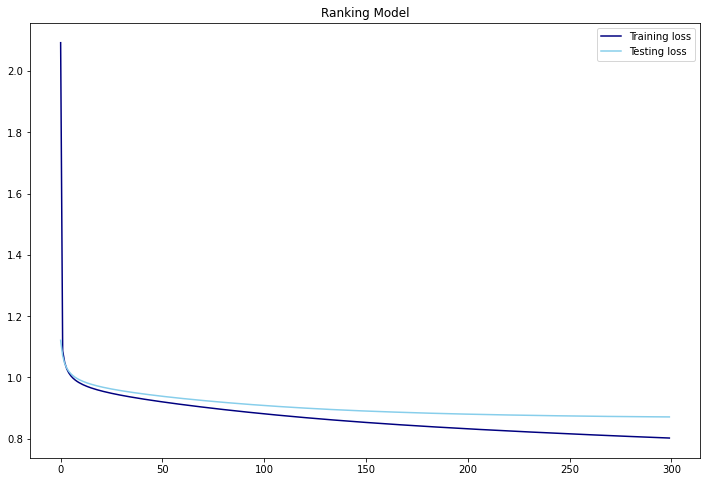

In [201]:
train_loss_ranking = ranking_history.history['root_mean_squared_error']
test_loss_ranking = ranking_history.history['val_root_mean_squared_error']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_ranking, label='Training loss', color='navy')
plt.plot(test_loss_ranking, label='Testing loss', color='skyblue')
plt.title('Ranking Model')
plt.legend();

Here again we can see that the model has overfit on training data. Let's take a look at the `test_rmse`. From the previous notebook, our best `SVD` model, after tuning had a `rmse` error of **0.8533**.

In [199]:
ranking_model_1.evaluate(cached_ranking_test, return_dict=True)

5/5 [==============================] - 0s 53ms/step - root_mean_squared_error: 0.8713 - loss: 0.7563 - regularization_loss: 0.0000e+00 - total_loss: 0.7563


{'root_mean_squared_error': 0.8713064193725586,
 'loss': 0.7439044713973999,
 'regularization_loss': 0,
 'total_loss': 0.7439044713973999}

As we can see here, we have managed to get a `test_rmse` of **0.8713**.<br>

Keep in mind we have not tuned our model yet! All we have done is that we have added in all of the features available in our dataset, and added 1 more dense layer of 32 neurons as seen in the model architecture earlier, and changed the learning rate to `0.01`. There is a high possibility that tuning the neural network model will most likely yield a model that has a high retrieval `accuracy`, and a low `rmse` of the rating prediction. 

---

# Getting Predictions

Now let's test out how we can obtain predicted ratings for some movies for a random `userId` from our `RankingModel`. We will use user number **512** as a test `userId`, and we will use `movieId` **1085**, **1544**, and **1931** as test movieIds. This method is defined in the guide which can be referred to [here](https://www.tensorflow.org/recommenders/examples/basic_ranking).

* For the `timestamp` feature, we will use the current time. In an actual scenario, the recommender system would need to provide recommendations in realtime, which means that it will use the actual time currently.
* The format required for `timestamp` is `Unix` time. This can be obtained by using the `time.time()` method.

In [203]:
# defining an empty dictionary to store the predicted ratings
test_ratings = {}

# defining the movie ids
test_movie_ids = [1085, 1544, 1931]

# for loop to put the movieIds and other 
# required variables through 
for movie_id in test_movie_ids:
    test_ratings[movie_id] = ranking_model_1({
      'userId': np.array([512]),
      'movieId': np.array([movie_id]),
      'timestamp': np.array([round(time.time())]),
      'genres': movie_df.loc[movie_df['movieId'] == movie_id, 'genres']\
        .values,
      'title': movie_df.loc[movie_df['movieId'] == movie_id, 'title']\
        .values
  }).numpy()[0][0]
    
# for loop to print out the ratings for userId 512

print('Ratings for userId 512:')
for movie_id, score in sorted(test_ratings.items(), 
                              key=lambda x: x[1], 
                              reverse=True):
    print(f"{movie_id}: {score}")

Ratings for userId 512:
1931: 4.1407341957092285
1544: 3.7178800106048584
1085: 3.5293071269989014


We are able to obtain the ratings for the movies, just by passing in the `userId` and the `movieId` features. The rest of the information can be obtained from the dataset itself. Now, let's combine the prediction method for the `RetrievalModel` and the `RankingModel` into 1 custom function.

---

# Custom Prediction Function

In [210]:
def get_top_movies(userID, num_of_movies=None):
    """This function accepts input of a userId (int), and outputs the 
    top 5 movies that should be recommender to them, with the predicted 
    rating the user will give. When loading the models, ensure that the 
    RetrievalModel is defined as 'retrieval_model', and the RankingModel 
    is definied as 'ranking_model. If this is not done, the function will 
    not work.'"""
    
    # defining userId
    userId = userID
    
    
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(retrieval_3_layer.query_model,
                                                k=100)

    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), 
                           movies.batch(100)\
                           .map(retrieval_3_layer\
                                .candidate_model\
                                .embedding_model\
                                .movie_id_embedding)
                          )
                         )
    )

    # Get recommendations for a random 'userId', 512
    _, m_ids = index({'userId': tf.constant([512]), 'timestamp': tf.constant([round(time.time())])})
    
    
    # takes the recommended movieIds and puts them through the ranking model
    
    test_movie_ids = [movie_id for movie_id in np.unique(m_ids)]
    
    timestamp = round(time.time())
    pred_dict = {}
    pred_dict['title'] = [movie_df.loc[movie_df['movieId'] == id, 'title'].values[0] 
                            for id in test_movie_ids]
    pred_dict['predicted_rating'] = [ranking_model_1({
            'userId': np.array([userId]), 
            'movieId': np.array([movie_id]), 
            'timestamp': np.array([timestamp]), 
            'genres': movie_df.loc[movie_df['movieId'] == movie_id, 'genres'].values, 
            'title': movie_df.loc[movie_df['movieId'] == movie_id, 'title'].values
        }).numpy()[0][0] for movie_id in test_movie_ids]
    pred_dict['userId'] = [userId for _ in test_movie_ids]
    pred_dict['movieId'] = test_movie_ids
    pred_dict['genres'] = [movie_df.loc[movie_df['movieId'] == id, 'genres'].values[0] 
                            for id in test_movie_ids]
    pred_dict['timestamp'] = [timestamp for id in test_movie_ids]
    
    
    
    pred_df = pd.DataFrame(pred_dict)
    pred_df.sort_values(by='predicted_rating', ascending=False, inplace=True)
    
    if num_of_movies and len(pred_df) > num_of_movies:
        return pred_df.head(num_of_movies)[['title', 'predicted_rating','userId']]
    else:
        return pred_df[['title', 'predicted_rating','userId']]

Now that we have a function, let's test it out.

We will simulate a real-life scenario by doing the following things.
1. We will pass in a random `userId` value from our dataset. 
2. We will use a real time `timestamp` value in `UNIX` format.
3. We will output the time taken for functino to execute, and output the recommendations.

In [213]:
%%time
get_top_movies(random.choice([user for user in range(1, 611)]), num_of_movies=5)

CPU times: total: 4.16 s
Wall time: 1.73 s


,title,predicted_rating,userId
4,Knockin' on Heaven's Door (1997),4.344704,39
19,"Master, The (2012)",4.150574,39
1,Monty Python Live at the Hollywood Bowl (1982),4.144925,39
27,London Town (2016),4.131389,39
25,Who Killed Chea Vichea? (2010),4.116331,39


In [214]:
%%time
get_top_movies(random.choice([user for user in range(1, 611)]), num_of_movies=5)

CPU times: total: 4.09 s
Wall time: 1.68 s


,title,predicted_rating,userId
25,Who Killed Chea Vichea? (2010),3.749257,57
4,Knockin' on Heaven's Door (1997),3.739535,57
27,London Town (2016),3.578048,57
12,Voices from the List (2004),3.540498,57
11,Casino Jack (2010),3.501882,57


In [215]:
%%time
get_top_movies(random.choice([user for user in range(1, 611)]), num_of_movies=5)

CPU times: total: 3.89 s
Wall time: 1.66 s


,title,predicted_rating,userId
4,Knockin' on Heaven's Door (1997),4.780338,554
27,London Town (2016),4.602211,554
12,Voices from the List (2004),4.590581,554
25,Who Killed Chea Vichea? (2010),4.478752,554
14,Carnage (2011),4.394801,554


In [216]:
%%time
get_top_movies(1310, num_of_movies=5)

CPU times: total: 4.36 s
Wall time: 1.93 s


,title,predicted_rating,userId
12,Voices from the List (2004),3.953906,1310
4,Knockin' on Heaven's Door (1997),3.947484,1310
25,Who Killed Chea Vichea? (2010),3.887461,1310
27,London Town (2016),3.674131,1310
16,"Art of Getting By, The (2011)",3.648631,1310


In [58]:
df[df['userId'] == 1310]

,userId,movieId,rating,timestamp,title,genres


Remember that we previously mentioned the threshold of **3 seconds**. As we can see from the above output, our model takes roughly 1-2 seconds to return predictions, the longest was for a the `userId` 1310 that is a new user. So we can see that the model does fall within the threshold and as a bonus, it can even solve the cold start problem!

---

# Overall Model Evaluation

## Pros of the Neural Network Model

* The `NN` can actually accept more than just the `userId`, `movieId` and `rating` features. I believe this is one of the biggest advantages of this model over the `SVD`.
* Since you can add in an additional embeddings for unknown tokens, the model above was actually able to give recommendations for a completely new user, that did not exist in the dataset. In order to evaluate the recommendations, we would need to create another simulation where we withhold that user data from the trainset.
* The ranking model was able to reach close to the `SVD` model `rmse` with a relatively low amount of effort considering that we haven't yet tuned the model. We have only touched on the depth of the model, and features in the model, no hyperparameter tuning.

## Cons of the Neural Network Model

* The `NN` model is not easy to train, and it is complicated to learn about the model as compared to the `SVD` model.
* Time taken to train the `NN` model can be hours or even days. In comparison, the `SVD` took just minutes to train on the 100k dataset.
* For deeper models, careful tuning of all the hyperparameters is required, including the number of dimensions for feature embedding. Without tuning, the model's performance will not be great.

---

# Next Steps

1. Further research can be done on how to obtain other user features like `age`, `occupation`, `geography` etc. With those kinds of features, especially those that are not user history dependent, we can solve the cold start problem and give the user some level of personalization in the recommendations presented to them.
2. Tuning the model. This goes without saying as we have mentioned preivously that most likely we need to explore tuning the model used here with the `Keras Tuner` library.
3. `Google` itself uses a `NN` recommender system for YouTube, and they have decided to implement a extreme multiclass classification model for the candidate retrieval part. I think further exploration into that is also possible, and some learnings from there can be implemented in your own `NN`. 

---

# Learnings from this challenge

## 1. There is never enough time to do all the things you wish to do in a project!

I learnt that the more I researched and pursused a method, the more I came across new information that I felt I HAD to include. It is very easy to go down the rabbit hole, so I think there is merit to give yourself a fixed scope to work within, and always check that you are indeed working within the scope.

## 2. I have learnt that even though figuring out information is difficult, with enough research, you can do it.


The `TensorFlow-Recommenders` library was completely new to me, and even though I had heard of Keras, I had not really had much contact with it. Figuring out how to use the library meant tons of research, and lots of trial and error, but by the end I think I gained the skill of how to search out information to help me, and how to make educational guesses of what the issue might be by following the logic in the code.

## 3. Take a break

Sometimes when I was really stumped on a problem, and I have searched all the stacked overflow forums, all the github posts, all the documentation, to no avail, I found that it helps me to stop. Do something else, take a short walk, anything. And then after about 20-30 mins later, sometimes, I magically have the solution. Or other times, I eventually figure it out because I am able to look at the problem again with a calm mind.

With these next steps and learnings, I look forward to exploring more about the up and coming research in recommender systems.